In [43]:
import sys
import subprocess
import pkg_resources

required = {'numpy', 'pandas', 'tensorflow', 'keras'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [45]:
# rm -rf keras_classification_sample

### Import images

In [46]:
import os
import random

if not os.path.exists('keras_classification_sample'):
  !git clone https://github.com/pazamelin/keras_classification_sample.git

IMG_DIR = f'./keras_classification_sample/concrete-cracks/'
CONFIG = {
    'image_size': (227, 227),
    'batch_size': 32,
    'validation_split': 0.2,
    'seed': random.randint(0, 99999) 
}

train_ds = tf.keras.utils.image_dataset_from_directory(IMG_DIR, **CONFIG, subset="training")
validation_ds = tf.keras.utils.image_dataset_from_directory(IMG_DIR, **CONFIG, subset="validation")

class_names = train_ds.class_names
print(f'Class_names: {class_names}')

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Class_names: ['negative', 'positive']


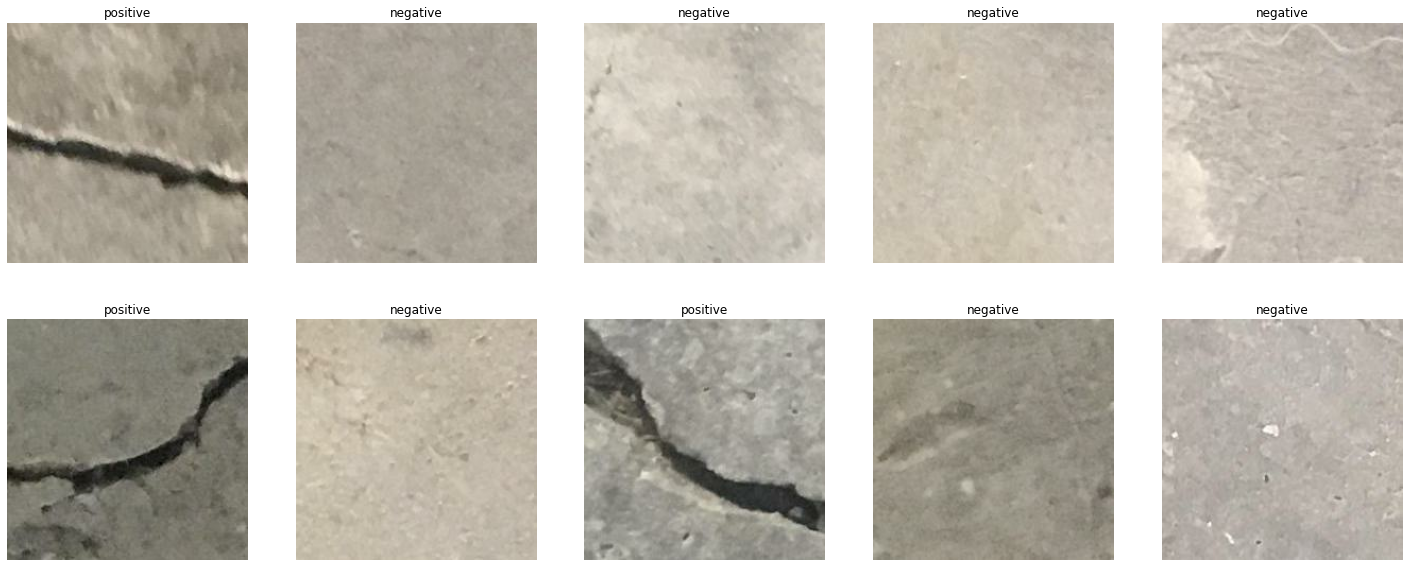

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Instantiate a model

In [48]:
from tensorflow.keras import models, layers

num_classes = 2

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(227, 227, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 225, 225, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 53, 53, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 128)      

### Configure the model for training

In [49]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Fit the model

In [50]:
history = model.fit(train_ds,
                    steps_per_epoch=25,
                    epochs=10,
                    validation_data=validation_ds,
                    validation_steps=50
)

Epoch 1/10
25/25 [==============================] - 6s 206ms/step - loss: 16.1274 - acc: 0.5263 - val_loss: 2.5209 - val_acc: 0.5831
Epoch 2/10
25/25 [==============================] - 5s 192ms/step - loss: 0.4710 - acc: 0.8637 - val_loss: 0.1162 - val_acc: 0.9619
Epoch 3/10
25/25 [==============================] - 5s 194ms/step - loss: 1.0613 - acc: 0.8525 - val_loss: 0.1280 - val_acc: 0.9663
Epoch 4/10
25/25 [==============================] - 5s 200ms/step - loss: 0.5237 - acc: 0.8763 - val_loss: 0.0965 - val_acc: 0.9669
Epoch 5/10
25/25 [==============================] - 6s 247ms/step - loss: 0.1083 - acc: 0.9700 - val_loss: 0.1067 - val_acc: 0.9650
Epoch 6/10
25/25 [==============================] - 6s 229ms/step - loss: 0.3678 - acc: 0.9312 - val_loss: 0.1272 - val_acc: 0.9725
Epoch 7/10
25/25 [==============================] - 5s 211ms/step - loss: 0.0812 - acc: 0.9787 - val_loss: 0.1242 - val_acc: 0.9688
Epoch 8/10
25/25 [==============================] - 5s 194ms/step - loss: 0

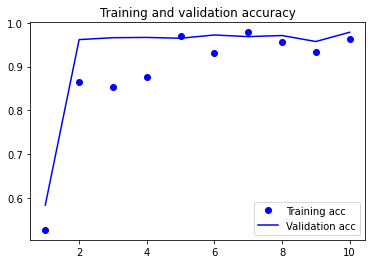

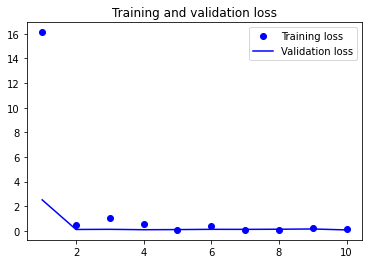

In [51]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()